In [1]:
# Cell 1: Import required libraries
import base64
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import json
import pandas as pd
import os
import seaborn as sns

In [2]:
# Cell 2: Data extraction functions
def extract_valid_results(jrzip_path):
    """Extract and validate results from JRZIP file"""
    def load_single_result(json_line):
        try:
            data = json.loads(json_line)
            # Check if this is a valid entry with required fields
            if (isinstance(data, dict) and 
                'metadata' in data and 
                'participant_id' in data['metadata']):
                return data
        except json.JSONDecodeError:
            return None
        return None

    valid_results = []
    with zipfile.ZipFile(jrzip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.txt'):
                with zip_ref.open(file_name) as f:
                    content = f.read().decode('utf-8')
                    for line in content.split('\n'):
                        if line.strip():
                            result = load_single_result(line)
                            if result:
                                valid_results.append(result)
    
    print(f"Found {len(valid_results)} valid results")
    return valid_results

In [3]:
# Cell 3: DataFrame creation functions
def create_participant_df(valid_results):
    """Create participant info DataFrame"""
    participant_info = []
    for result in valid_results:
        info = {
            'participant_id': result['metadata']['participant_id'],
            'timestamp': result['metadata']['timestamp'],
            'filter_threshold': result['metadata']['parameters']['filter_parameters']['threshold'],
            'preservation_factor': result['metadata']['parameters']['filter_parameters']['preservation_factor'],
            'noise_reduction': result['metadata']['parameters']['filter_parameters']['noise_reduction_factor']
        }
        participant_info.append(info)
    return pd.DataFrame(participant_info).set_index('participant_id')

def create_training_df(valid_results):
    """Create training phase DataFrame"""
    training_data = []
    for result in valid_results:
        if isinstance(result.get('training_phase'), dict):
            training = {
                'participant_id': result['metadata']['participant_id'],
                'total_trials': result['training_phase']['summary']['total_trials'],
                'correct_trials': result['training_phase']['summary']['correct_trials'],
                'accuracy': result['training_phase']['summary']['accuracy_percentage'],
                'mean_rt': result['training_phase']['summary']['mean_rt']
            }
            training_data.append(training)
    return pd.DataFrame(training_data).set_index('participant_id')

def create_vviq_df(valid_results):
    """Create VVIQ DataFrame with attention check validation"""
    vviq_data = []
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        vviq_metadata = result['metadata'].get('vviq_data', {})
        
        # Check attention checks
        attention_checks = vviq_metadata.get('attention_check_passed', {})
        
        for eye_condition in ['eyes_open', 'eyes_closed']:
            responses = vviq_metadata.get(eye_condition, [])
            for response in responses:
                for item, rating in response.get('responses', {}).items():
                    vviq_data.append({
                        'participant_id': participant_id,
                        'condition': eye_condition,
                        'question_index': response.get('question_index'),
                        'item': item,
                        'rating': rating,
                        'attention_check_passed': attention_checks.get(eye_condition, False)
                    })
    return pd.DataFrame(vviq_data)

def create_caps_df(valid_results):
    """Create CAPS DataFrame"""
    caps_data = []
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        caps_responses = result['metadata'].get('caps_data', [])
        
        for response in caps_responses:
            caps_data.append({
                'participant_id': participant_id,
                'question_index': response.get('question_index'),
                'question_text': response.get('question_text'),
                'response': response.get('response'),
                'subscale': response.get('subscale')
            })
    return pd.DataFrame(caps_data)

def create_evolution_df(valid_results):
    """Create evolution DataFrame"""
    evolution_data = []
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        for entry in result['evolution_summary']:
            evolution_data.append({
                'participant_id': participant_id,
                'session': entry['session'],
                'generation': entry['generation'],
                'n_selections': len(entry['selected_parents'])
            })
    return pd.DataFrame(evolution_data)

In [4]:
# Cell 4: Analysis functions
def analyze_attention_checks(vviq_df):
    """Analyze VVIQ attention check performance"""
    attention_summary = vviq_df.groupby('participant_id')['attention_check_passed'].agg(['first', 'count'])
    attention_summary.columns = ['passed_check', 'total_responses']
    return attention_summary

def analyze_training_performance(training_df):
    """Analyze training phase performance"""
    performance_summary = training_df.agg({
        'accuracy': ['mean', 'std', 'min', 'max'],
        'mean_rt': ['mean', 'std']
    }).round(2)
    return performance_summary

In [5]:
# Cell 5: Usage example
#jrzip_path = "jatos_results_20241209_filtered_post5074.jrzip" #this one is without me and guido
#jrzip_path = "jatos_results_20241211_latest.jrzip"
#jrzip_path = "jatos_results_20241209150149.jrzip" #this one is with  me and guido
#jrzip_path = "jatos_results_20241212_withMiguelito.jrzip" #this is all valid with muguelito as -1, i.e. non SONA participant
jrzip_path = "jatos_results_20250207155153.jrzip" #Final valid SONA batch
valid_results = extract_valid_results(jrzip_path)

# Create all DataFrames
dfs = {
    'participants': create_participant_df(valid_results),
    'training': create_training_df(valid_results),
    'vviq': create_vviq_df(valid_results),
    'caps': create_caps_df(valid_results),
    'evolution': create_evolution_df(valid_results)
}

# Print basic info about each DataFrame
for name, df in dfs.items():
    print(f"\n{name} DataFrame shape:", df.shape)
    print(f"Columns:", df.columns.tolist())

# Analyze attention checks and training performance
attention_summary = analyze_attention_checks(dfs['vviq'])
training_summary = analyze_training_performance(dfs['training'])

print("\nVVIQ Attention Check Summary:")
print(attention_summary)
print("\nTraining Performance Summary:")
print(training_summary)

Found 85 valid results

participants DataFrame shape: (85, 4)
Columns: ['timestamp', 'filter_threshold', 'preservation_factor', 'noise_reduction']

training DataFrame shape: (82, 4)
Columns: ['total_trials', 'correct_trials', 'accuracy', 'mean_rt']

vviq DataFrame shape: (2890, 6)
Columns: ['participant_id', 'condition', 'question_index', 'item', 'rating', 'attention_check_passed']

caps DataFrame shape: (2720, 5)
Columns: ['participant_id', 'question_index', 'question_text', 'response', 'subscale']

evolution DataFrame shape: (1190, 4)
Columns: ['participant_id', 'session', 'generation', 'n_selections']

VVIQ Attention Check Summary:
                passed_check  total_responses
participant_id                               
-1                      True               34
11893                  False               34
11911                   True               68
11914                   True               34
11929                   True               34
...                      ...       

In [6]:
# Cell 1: Improved attention check identification
def identify_failed_attention_checks(dfs):
    vviq_df = dfs['vviq']
    
    # Group by participant and ensure ALL attention checks are passed
    attention_status = vviq_df.groupby('participant_id')['attention_check_passed'].agg(
        lambda x: all(x)  # Must pass ALL attention checks
    )
    
    # Get participants who failed any attention check
    failed_participants = attention_status[~attention_status].index.tolist()
    
    print("\nAttention check status per participant:")
    print(attention_status)
    print(f"\nFound {len(failed_participants)} participants who failed at least one attention check")
    print("Failed Participant IDs:", failed_participants)
    
    return failed_participants

# Cell 2: Separate naughty participants
def separate_naughty_participants(dfs, failed_participants):
    naughty_dfs = {}
    clean_dfs = {}
    
    for name, df in dfs.items():
        if df.index.name == 'participant_id':
            # For DataFrames indexed by participant_id
            naughty_dfs[name] = df.loc[df.index.isin(failed_participants)]
            clean_dfs[name] = df.loc[~df.index.isin(failed_participants)]
        else:
            # For DataFrames with participant_id as a column
            naughty_dfs[name] = df[df['participant_id'].isin(failed_participants)]
            clean_dfs[name] = df[~df['participant_id'].isin(failed_participants)]
    
    # Print summary of removed participants
    print("\nParticipants removed from analysis:")
    for participant in failed_participants:
        print(f"\nParticipant {participant}:")
        for name, df in naughty_dfs.items():
            if df.index.name == 'participant_id' and participant in df.index:
                print(f"- Found in {name} DataFrame")
    
    return clean_dfs, naughty_dfs

# Cell 3: Usage
failed_participants = identify_failed_attention_checks(dfs)
clean_dfs, naughty_dfs = separate_naughty_participants(dfs, failed_participants)

# Cell 4: Verification
print("\nVerification of clean DataFrames:")
for name, df in clean_dfs.items():
    if df.index.name == 'participant_id':
        print(f"\n{name} remaining participants:", len(df))
    else:
        print(f"\n{name} remaining entries:", len(df))


Attention check status per participant:
participant_id
-1        True
11893    False
11911     True
11914     True
11929     True
         ...  
15052     True
15169     True
4702     False
4737      True
4739      True
Name: attention_check_passed, Length: 76, dtype: bool

Found 7 participants who failed at least one attention check
Failed Participant IDs: ['11893', '12049', '12136', '12235', '13471', '14269', '4702']

Participants removed from analysis:

Participant 11893:
- Found in participants DataFrame
- Found in training DataFrame

Participant 12049:
- Found in participants DataFrame
- Found in training DataFrame

Participant 12136:
- Found in participants DataFrame
- Found in training DataFrame

Participant 12235:
- Found in participants DataFrame
- Found in training DataFrame

Participant 13471:
- Found in participants DataFrame
- Found in training DataFrame

Participant 14269:
- Found in participants DataFrame
- Found in training DataFrame

Participant 4702:
- Found in parti

Training Data Summary:
                total_trials  correct_trials  accuracy       mean_rt
participant_id                                                      
15169                    227               9        90    830.068780
12109                    227              10       100  22755.707317
11974                    227               8        80   5460.162439
13615                    227               0         0   8877.292195
12040                    227               6        60  15302.214634
...                      ...             ...       ...           ...
13666                    227               6        60   1568.936098
13246                    227               9        90   7919.712195
11983                    227               3        30   8758.148293
12475                    227               7        70  11805.332195
12070                    227              10       100  17024.082927

[75 rows x 4 columns]


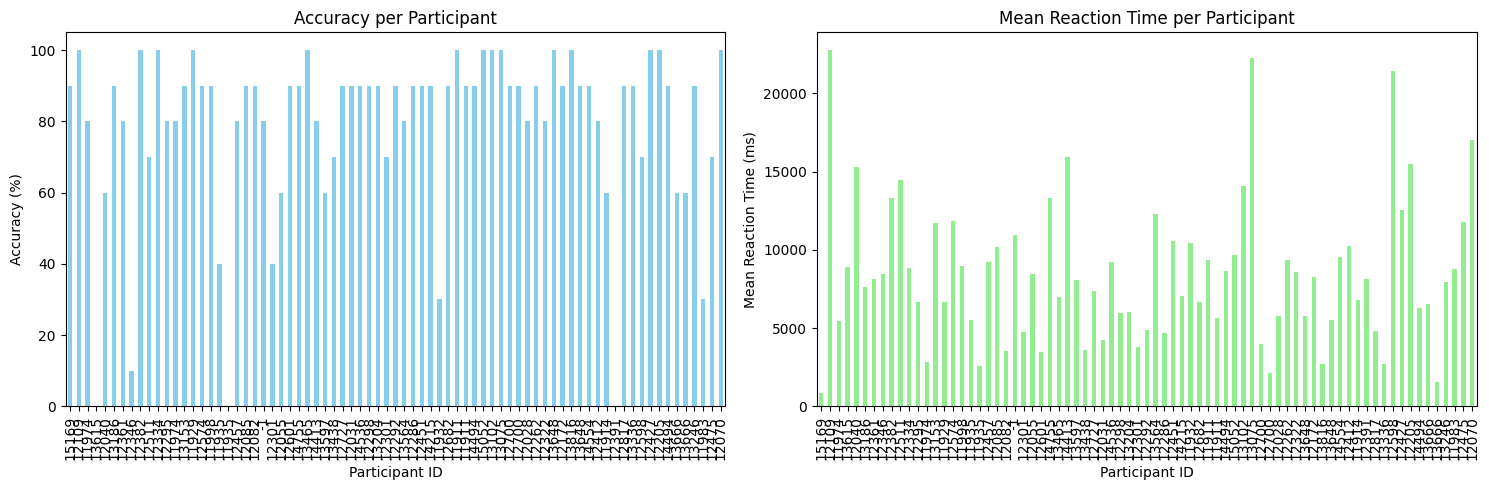

In [7]:
# Display training data summary
print("Training Data Summary:")
print(clean_dfs['training'])

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
clean_dfs['training']['accuracy'].plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Accuracy per Participant')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xlabel('Participant ID')

# Reaction time plot
clean_dfs['training']['mean_rt'].plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Mean Reaction Time per Participant')
ax2.set_ylabel('Mean Reaction Time (ms)')
ax2.set_xlabel('Participant ID')

plt.tight_layout()
plt.show()


In [8]:
 # Cell 1: Helper functions for image processing
def decode_base64_image(base64_string_or_list):
    if isinstance(base64_string_or_list, list):
        base64_string = base64_string_or_list[0]
    else:
        base64_string = base64_string_or_list
    
    try:
        img_data = base64.b64decode(base64_string.split(',')[1])
    except IndexError:
        img_data = base64.b64decode(base64_string)
    
    return Image.open(BytesIO(img_data))

def create_composite_image(images):
    if not images:
        return np.zeros((16, 16), dtype=np.uint8)
    np_images = [np.array(img.convert('L').resize((16, 16))) for img in images]
    mean_image = np.mean(np.stack(np_images), axis=0)
    return mean_image.astype(np.uint8)

# Cell 3: Visualization function
def plot_participant_sessions(participant_data, participant_id):
    for session, session_data in participant_data.items():
        generations = sorted(session_data.keys())
        n_gens = len(generations)
        
        if n_gens == 0:
            print(f"No generations found for Participant {participant_id}, Session {session}")
            continue
            
        fig, axes = plt.subplots(1, n_gens, figsize=(3*n_gens, 3))
        if n_gens == 1:
            axes = [axes]
        
        for idx, gen in enumerate(generations):
            gen_images = []
            for img_base64 in session_data[gen]['selected']:
                try:
                    img = decode_base64_image(img_base64)
                    gen_images.append(img)
                except Exception as e:
                    print(f"Error processing image for Participant {participant_id}, Session {session}, Generation {gen}: {str(e)}")
                    continue
                    
            if gen_images:
                composite = create_composite_image(gen_images)
                axes[idx].imshow(composite, cmap='gray')
                axes[idx].axis('off')
                axes[idx].set_title(f'Gen {gen}')
        
        plt.suptitle(f'Participant {participant_id} - Session {session}')
        plt.tight_layout()
        plt.show()
        plt.close()

In [9]:
def calculate_vviq_scores(df):
    # Remove item_5 (attention check)
    df_no_checks = df[df['item'] != 'item_5']
    
    # Flip scores (1->5, 2->4, 3->3, 4->2, 5->1) for interpretability
    df_no_checks['flipped_rating'] = 6 - df_no_checks['rating']
    
    # Initialize results dictionary
    participant_scores = {}
    
    # Calculate scores for each participant
    for participant_id in df_no_checks['participant_id'].unique():
        participant_data = df_no_checks[df_no_checks['participant_id'] == participant_id]
        scores = {}
        
        # Calculate raw scores for each condition
        for condition in ['eyes_open', 'eyes_closed']:
            condition_scores = participant_data[participant_data['condition'] == condition]['flipped_rating'].sum()
            scores[f'{condition}_raw'] = condition_scores
            scores[f'{condition}_normalized'] = condition_scores / 80  # 4 items * 4 questions * 5 points
        
        # Calculate total scores
        scores['total_raw'] = scores['eyes_open_raw'] + scores['eyes_closed_raw']
        scores['total_normalized'] = scores['total_raw'] / 160
        
        participant_scores[participant_id] = scores
    
    # Convert to DataFrame for easier handling
    scores_df = pd.DataFrame.from_dict(participant_scores, orient='index')
    
    return scores_df

# Apply the function to your dataframe
vviq_scores_by_participant = calculate_vviq_scores(clean_dfs['vviq'])

# The resulting DataFrame will look like this:
# participant_id | eyes_open_raw | eyes_closed_raw | eyes_open_normalized | eyes_closed_normalized | total_raw | total_normalized

C:\Users\saith\AppData\Local\Temp\ipykernel_38664\2434062976.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_checks['flipped_rating'] = 6 - df_no_checks['rating']


C:\Users\saith\AppData\Local\Temp\ipykernel_38664\1291616270.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(['Eyes Open', 'Eyes Closed'])
C:\Users\saith\AppData\Local\Temp\ipykernel_38664\1291616270.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(['Eyes Open', 'Eyes Closed'])


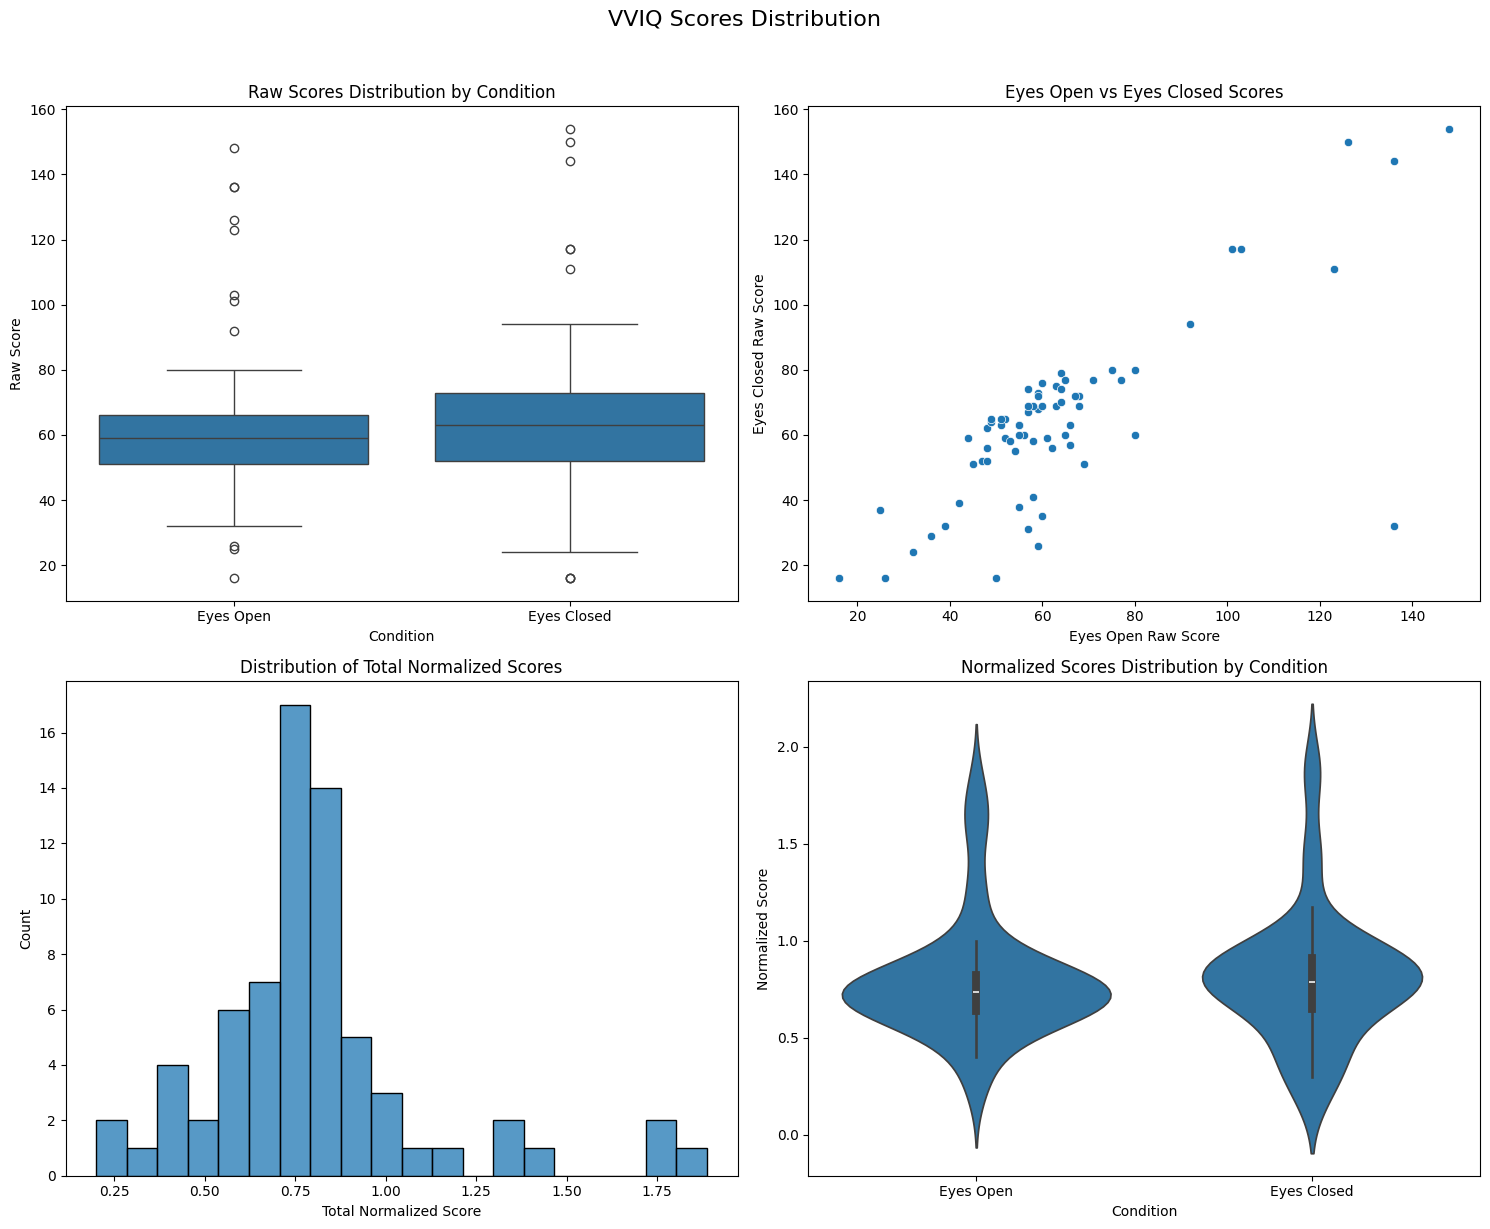

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_vviq_scores(scores_df):
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('VVIQ Scores Distribution', fontsize=16, y=1.02)

    # Plot 1: Boxplot comparing eyes open vs closed (raw scores)
    comparison_data = pd.melt(scores_df[['eyes_open_raw', 'eyes_closed_raw']], 
                            var_name='Condition', value_name='Raw Score')
    sns.boxplot(data=comparison_data, x='Condition', y='Raw Score', ax=axes[0,0])
    axes[0,0].set_title('Raw Scores Distribution by Condition')
    axes[0,0].set_xticklabels(['Eyes Open', 'Eyes Closed'])

    # Plot 2: Scatter plot of eyes open vs closed
    sns.scatterplot(data=scores_df, x='eyes_open_raw', y='eyes_closed_raw', ax=axes[0,1])
    axes[0,1].set_title('Eyes Open vs Eyes Closed Scores')
    axes[0,1].set_xlabel('Eyes Open Raw Score')
    axes[0,1].set_ylabel('Eyes Closed Raw Score')

    # Plot 3: Histogram of total normalized scores
    sns.histplot(data=scores_df, x='total_normalized', bins=20, ax=axes[1,0])
    axes[1,0].set_title('Distribution of Total Normalized Scores')
    axes[1,0].set_xlabel('Total Normalized Score')
    axes[1,0].set_ylabel('Count')

    # Plot 4: Violin plot of normalized scores by condition
    normalized_data = pd.melt(scores_df[['eyes_open_normalized', 'eyes_closed_normalized']], 
                            var_name='Condition', value_name='Normalized Score')
    sns.violinplot(data=normalized_data, x='Condition', y='Normalized Score', ax=axes[1,1])
    axes[1,1].set_title('Normalized Scores Distribution by Condition')
    axes[1,1].set_xticklabels(['Eyes Open', 'Eyes Closed'])

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Create the plots
plot_vviq_scores(vviq_scores_by_participant)

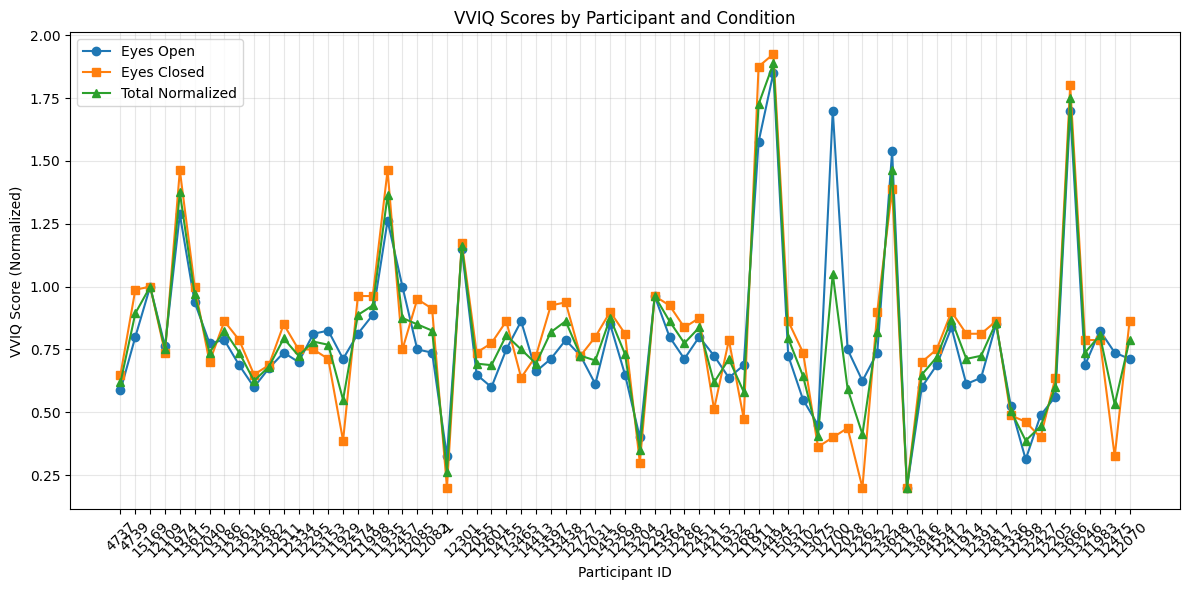

In [11]:
import matplotlib.pyplot as plt

# Create visualization
plt.figure(figsize=(12, 6))

# Plot individual scores
x = range(len(vviq_scores_by_participant))
plt.plot(x, vviq_scores_by_participant['eyes_open_normalized'], 'o-', label='Eyes Open')
plt.plot(x, vviq_scores_by_participant['eyes_closed_normalized'], 's-', label='Eyes Closed')
plt.plot(x, vviq_scores_by_participant['total_normalized'], '^-', label='Total Normalized')

# Add labels and title
plt.xticks(x, vviq_scores_by_participant.index, rotation=45)
plt.xlabel('Participant ID')
plt.ylabel('VVIQ Score (Normalized)')
plt.title('VVIQ Scores by Participant and Condition')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
import pingouin as pg

# First, let's reshape the data to get all items (excluding item_5) in columns
vviq_items = clean_dfs['vviq'][clean_dfs['vviq']['item'] != 'item_5']

# Use pivot_table instead of pivot to handle duplicates
vviq_wide = vviq_items.pivot_table(index=['participant_id', 'condition'], 
                                  columns='item', 
                                  values='rating',
                                  aggfunc='first').reset_index()

# Calculate alpha separately for each condition
for condition in ['eyes_open', 'eyes_closed']:
    condition_data = vviq_wide[vviq_wide['condition'] == condition].iloc[:, 2:]  # Select only rating columns
    alpha = pg.cronbach_alpha(data=condition_data)
    print(f"\nCronbach's alpha for {condition}: {alpha[0]:.3f}")
    print(f"95% CI: [{alpha[1][0]:.3f}, {alpha[1][1]:.3f}]")

# Calculate overall alpha combining both conditions
all_data = vviq_items.pivot_table(index='participant_id', 
                                 columns=['condition', 'item'], 
                                 values='rating',
                                 aggfunc='first')
alpha_total = pg.cronbach_alpha(data=all_data)
print(f"\nOverall Cronbach's alpha: {alpha_total[0]:.3f}")
print(f"95% CI: [{alpha_total[1][0]:.3f}, {alpha_total[1][1]:.3f}]")


Cronbach's alpha for eyes_open: 0.798
95% CI: [0.706, 0.866]

Cronbach's alpha for eyes_closed: 0.892
95% CI: [0.843, 0.928]

Overall Cronbach's alpha: 0.888
95% CI: [0.843, 0.924]



Correlations with Training Accuracy:

eyes_open_normalized:
r = -0.057
p = 0.625

eyes_closed_normalized:
r = -0.161
p = 0.169

total_normalized:
r = -0.118
p = 0.313


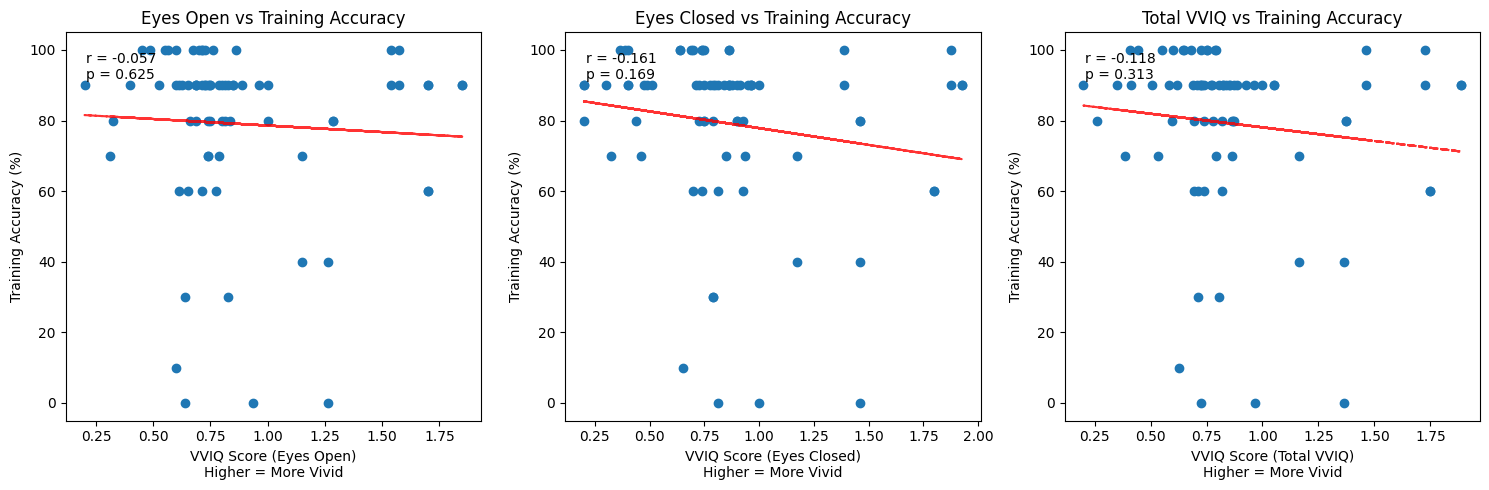

In [13]:
def correlate_vviq_training(clean_dfs, vviq_scores_by_participant):
    # Get training accuracy and reset index to avoid duplicates
    training_accuracy = clean_dfs['training']['accuracy'].reset_index()
    
    # Merge data on participant_id
    correlation_df = pd.merge(
        training_accuracy, 
        vviq_scores_by_participant,
        left_on='participant_id',
        right_index=True
    )
    
    # Calculate correlations
    correlations = {}
    p_values = {}
    # Update measures to match our new column names
    for vviq_measure in ['eyes_open_normalized', 'eyes_closed_normalized', 'total_normalized']:
        r, p = stats.pearsonr(correlation_df['accuracy'], 
                            correlation_df[vviq_measure])
        correlations[vviq_measure] = r
        p_values[vviq_measure] = p
    
    # Print results
    print("\nCorrelations with Training Accuracy:")
    for measure in correlations:
        print(f"\n{measure}:")
        print(f"r = {correlations[measure]:.3f}")
        print(f"p = {p_values[measure]:.3f}")
    
    # Create scatter plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    measures = ['eyes_open_normalized', 'eyes_closed_normalized', 'total_normalized']
    titles = ['Eyes Open', 'Eyes Closed', 'Total VVIQ']
    
    for ax, measure, title in zip(axes, measures, titles):
        ax.scatter(correlation_df[measure], correlation_df['accuracy'])
        ax.set_xlabel(f'VVIQ Score ({title})\nHigher = More Vivid')  # Note: changed interpretation
        ax.set_ylabel('Training Accuracy (%)')
        ax.set_title(f'{title} vs Training Accuracy')
        
        # Add trend line
        z = np.polyfit(correlation_df[measure], correlation_df['accuracy'], 1)
        p = np.poly1d(z)
        ax.plot(correlation_df[measure], p(correlation_df[measure]), "r--", alpha=0.8)
        
        # Add correlation coefficient and p-value
        ax.text(0.05, 0.95, f'r = {correlations[measure]:.3f}\np = {p_values[measure]:.3f}', 
                transform=ax.transAxes, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    return correlation_df, correlations, p_values

# Run the correlation analysis
from scipy import stats
correlation_results = correlate_vviq_training(clean_dfs, vviq_scores_by_participant)

Removed 8 participants with accuracy below 50%


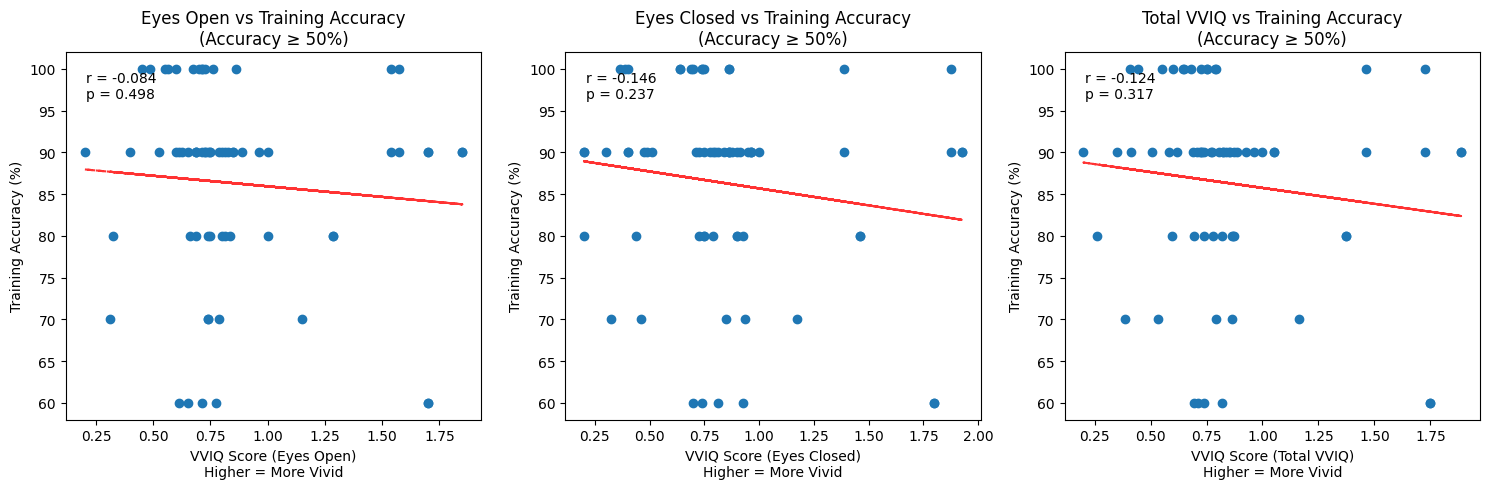

In [14]:
def correlate_vviq_training_filtered(clean_dfs, vviq_scores_by_participant, accuracy_threshold=50):
    # Get training accuracy and reset index
    training_accuracy = clean_dfs['training']['accuracy'].reset_index()
    
    # Merge data and filter by accuracy threshold
    correlation_df = pd.merge(
        training_accuracy, 
        vviq_scores_by_participant,
        left_on='participant_id',
        right_index=True
    )
    filtered_df = correlation_df[correlation_df['accuracy'] >= accuracy_threshold]
    
    print(f"Removed {len(correlation_df) - len(filtered_df)} participants with accuracy below {accuracy_threshold}%")
    
    # Calculate correlations with filtered data
    correlations = {}
    p_values = {}
    for vviq_measure in ['eyes_open_normalized', 'eyes_closed_normalized', 'total_normalized']:
        r, p = stats.pearsonr(filtered_df['accuracy'], 
                            filtered_df[vviq_measure])
        correlations[vviq_measure] = r
        p_values[vviq_measure] = p
    
    # Create scatter plots with filtered data
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    measures = ['eyes_open_normalized', 'eyes_closed_normalized', 'total_normalized']
    titles = ['Eyes Open', 'Eyes Closed', 'Total VVIQ']
    
    for ax, measure, title in zip(axes, measures, titles):
        ax.scatter(filtered_df[measure], filtered_df['accuracy'])
        ax.set_xlabel(f'VVIQ Score ({title})\nHigher = More Vivid')
        ax.set_ylabel('Training Accuracy (%)')
        ax.set_title(f'{title} vs Training Accuracy\n(Accuracy ≥ {accuracy_threshold}%)')
        
        # Add trend line
        z = np.polyfit(filtered_df[measure], filtered_df['accuracy'], 1)
        p = np.poly1d(z)
        ax.plot(filtered_df[measure], p(filtered_df[measure]), "r--", alpha=0.8)
        
        # Add correlation coefficient and p-value
        ax.text(0.05, 0.95, f'r = {correlations[measure]:.3f}\np = {p_values[measure]:.3f}', 
                transform=ax.transAxes, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    return filtered_df, correlations, p_values

# Run the filtered analysis
filtered_results = correlate_vviq_training_filtered(clean_dfs, vviq_scores_by_participant, accuracy_threshold=50)

In [30]:
def analyze_caps_scores_wrong(caps_df):
    """Analyze CAPS scores with dimensions, subscales, and comprehensive visual perception items."""
    
    # Define dimension questions (based on factor analysis)
    dimensions = {
        'temporal_lobe': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'chemosensation': [26, 27, 28, 29],
        'clinical_psychosis': [30, 31, 32]
    }
    
    # Define comprehensive visual perception questions
    visual_questions = [
        1,  # lights/colors more intense
        3,  # shapes, lights, colors
        19, # patterns, pictures, faces (pareidolia)
        20, # vision more sensitive
        26, # see things others cannot
        23, # reality vs dream difficulty
        24  # peripheral vision phenomena
    ]
    
    scores_by_participant = {}
    
    for participant_id in caps_df['participant_id'].unique():
        participant_data = caps_df[caps_df['participant_id'] == participant_id]
        
        # Initialize scores dictionary
        scores = {
            # Basic counts
            'total_yes_raw_caps': 0,
            
            # Subscale totals
            'distressing_total_raw_caps': 0,
            'distracting_total_raw_caps': 0,
            'frequency_total_raw_caps': 0,
            
            # Dimension scores
            'temporal_lobe_score_raw_caps': 0,
            'chemosensation_score_raw_caps': 0,
            'clinical_psychosis_score_raw_caps': 0,
            
            # Visual scores
            'visual_yes_count_raw_caps': 0,
            'visual_distressing_raw_caps': 0,
            'visual_distracting_raw_caps': 0,
            'visual_frequency_raw_caps': 0,
            'visual_total_raw_caps': 0
        }
        
        # Calculate scores
        for _, row in participant_data.iterrows():
            question_idx = row['question_index']
            
            if row['response'] == 'yes':
                scores['total_yes_raw_caps'] += 1
                
                if row['subscale'] is not None:
                    # Add to general subscales
                    scores['distressing_total_raw_caps'] += row['subscale'].get('distressing', 0)
                    scores['distracting_total_raw_caps'] += row['subscale'].get('distracting', 0)
                    scores['frequency_total_raw_caps'] += row['subscale'].get('frequency', 0)
                    
                    # Add to dimension scores
                    for dim, questions in dimensions.items():
                        if question_idx in questions:
                            scores[f'{dim}_score_raw_caps'] += sum(row['subscale'].values())
                    
                    # Add to visual scores
                    if question_idx in visual_questions:
                        scores['visual_yes_count_raw_caps'] += 1
                        scores['visual_distressing_raw_caps'] += row['subscale'].get('distressing', 0)
                        scores['visual_distracting_raw_caps'] += row['subscale'].get('distracting', 0)
                        scores['visual_frequency_raw_caps'] += row['subscale'].get('frequency', 0)
                        scores['visual_total_raw_caps'] += sum(row['subscale'].values())
        
        scores_by_participant[participant_id] = scores
    
    # Convert to DataFrame
    raw_scores_df = pd.DataFrame.from_dict(scores_by_participant, orient='index')
    
    # Normalize the raw scores (divide by max possible score for each measure)
    max_scores = {col: raw_scores_df[col].max() for col in raw_scores_df.columns}
    normalized_scores_df = raw_scores_df.div(max_scores).add_suffix('_normalized')
    
    # Rename normalized columns to follow proper naming conventions
    normalized_scores_df.columns = [
        col.replace('_raw_caps_normalized', '_normalized_caps') for col in normalized_scores_df.columns
    ]
    
    # Combine raw and normalized data into one DataFrame
    combined_scores_df = pd.concat([raw_scores_df, normalized_scores_df], axis=1)
    
    return combined_scores_df

# Run the updated analysis function
caps_scores_by_participant_wrong = analyze_caps_scores_wrong(clean_dfs['caps'])

In [31]:
def analyze_caps_scores(caps_df):
    """Analyze CAPS scores with dimensions, subscales, and comprehensive visual perception items."""
    
    # Define dimension questions (based on factor analysis)
    dimensions = {
        'temporal_lobe': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'chemosensation': [26, 27, 28, 29],
        'clinical_psychosis': [30, 31, 32]
    }
    
    # Define comprehensive visual perception questions
    visual_questions = [
        1,  # lights/colors more intense
        3,  # shapes, lights, colors
        19, # patterns, pictures, faces (pareidolia)
        20, # vision more sensitive
        26, # see things others cannot
        23, # reality vs dream difficulty
        24  # peripheral vision phenomena
    ]
    
    # Define theoretical maximums
    theoretical_max = {
        'total_yes_raw_caps': len(caps_df['question_index'].unique()),
        'distressing_total_raw_caps': len(caps_df['question_index'].unique()) * 5,
        'distracting_total_raw_caps': len(caps_df['question_index'].unique()) * 5,
        'frequency_total_raw_caps': len(caps_df['question_index'].unique()) * 5,
        'temporal_lobe_score_raw_caps': len(dimensions['temporal_lobe']) * 5,
        'chemosensation_score_raw_caps': len(dimensions['chemosensation']) * 5,
        'clinical_psychosis_score_raw_caps': len(dimensions['clinical_psychosis']) * 5,
        'visual_yes_count_raw_caps': len(visual_questions),
        'visual_distressing_raw_caps': len(visual_questions) * 5,
        'visual_distracting_raw_caps': len(visual_questions) * 5,
        'visual_frequency_raw_caps': len(visual_questions) * 5,
        'visual_total_raw_caps': len(visual_questions) * 15
    }
    
    scores_by_participant = {}
    
    for participant_id in caps_df['participant_id'].unique():
        participant_data = caps_df[caps_df['participant_id'] == participant_id]
        
        # Initialize scores dictionary
        scores = {key: 0 for key in theoretical_max.keys()}
        
        # Calculate scores
        for _, row in participant_data.iterrows():
            question_idx = row['question_index']
            
            if row['response'] == 'yes':
                scores['total_yes_raw_caps'] += 1
                
                if row['subscale'] is not None:
                    # Add to general subscales
                    scores['distressing_total_raw_caps'] += row['subscale'].get('distressing', 0)
                    scores['distracting_total_raw_caps'] += row['subscale'].get('distracting', 0)
                    scores['frequency_total_raw_caps'] += row['subscale'].get('frequency', 0)
                    
                    # Add to dimension scores
                    for dim, questions in dimensions.items():
                        if question_idx in questions:
                            scores[f'{dim}_score_raw_caps'] += sum(row['subscale'].values())
                    
                    # Add to visual scores
                    if question_idx in visual_questions:
                        scores['visual_yes_count_raw_caps'] += 1
                        scores['visual_distressing_raw_caps'] += row['subscale'].get('distressing', 0)
                        scores['visual_distracting_raw_caps'] += row['subscale'].get('distracting', 0)
                        scores['visual_frequency_raw_caps'] += row['subscale'].get('frequency', 0)
                        scores['visual_total_raw_caps'] += sum(row['subscale'].values())
        
        scores_by_participant[participant_id] = scores
    
    # Convert to DataFrame
    raw_scores_df = pd.DataFrame.from_dict(scores_by_participant, orient='index')
    
    # Normalize using theoretical maximums
    normalized_scores_df = raw_scores_df.div(pd.Series(theoretical_max)).add_suffix('_normalized')

        # Rename normalized columns to follow proper naming conventions
    normalized_scores_df.columns = [
        col.replace('_raw_caps_normalized', '_normalized_caps') for col in normalized_scores_df.columns
    ]
    
    # Combine raw and normalized data into one DataFrame
    combined_scores_df = pd.concat([raw_scores_df, normalized_scores_df], axis=1)
    
    return combined_scores_df

# Run the updated analysis function
caps_scores_by_participant = analyze_caps_scores(clean_dfs['caps'])

In [32]:
# Check the structure and columns of the DataFrame
print(caps_scores_by_participant.columns)

# Display the first few rows to inspect the data
print(caps_scores_by_participant.head())

Index(['total_yes_raw_caps', 'distressing_total_raw_caps',
       'distracting_total_raw_caps', 'frequency_total_raw_caps',
       'temporal_lobe_score_raw_caps', 'chemosensation_score_raw_caps',
       'clinical_psychosis_score_raw_caps', 'visual_yes_count_raw_caps',
       'visual_distressing_raw_caps', 'visual_distracting_raw_caps',
       'visual_frequency_raw_caps', 'visual_total_raw_caps',
       'total_yes_normalized_caps', 'distressing_total_normalized_caps',
       'distracting_total_normalized_caps', 'frequency_total_normalized_caps',
       'temporal_lobe_score_normalized_caps',
       'chemosensation_score_normalized_caps',
       'clinical_psychosis_score_normalized_caps',
       'visual_yes_count_normalized_caps',
       'visual_distressing_normalized_caps',
       'visual_distracting_normalized_caps',
       'visual_frequency_normalized_caps', 'visual_total_normalized_caps'],
      dtype='object')
       total_yes_raw_caps  distressing_total_raw_caps  \
4737             

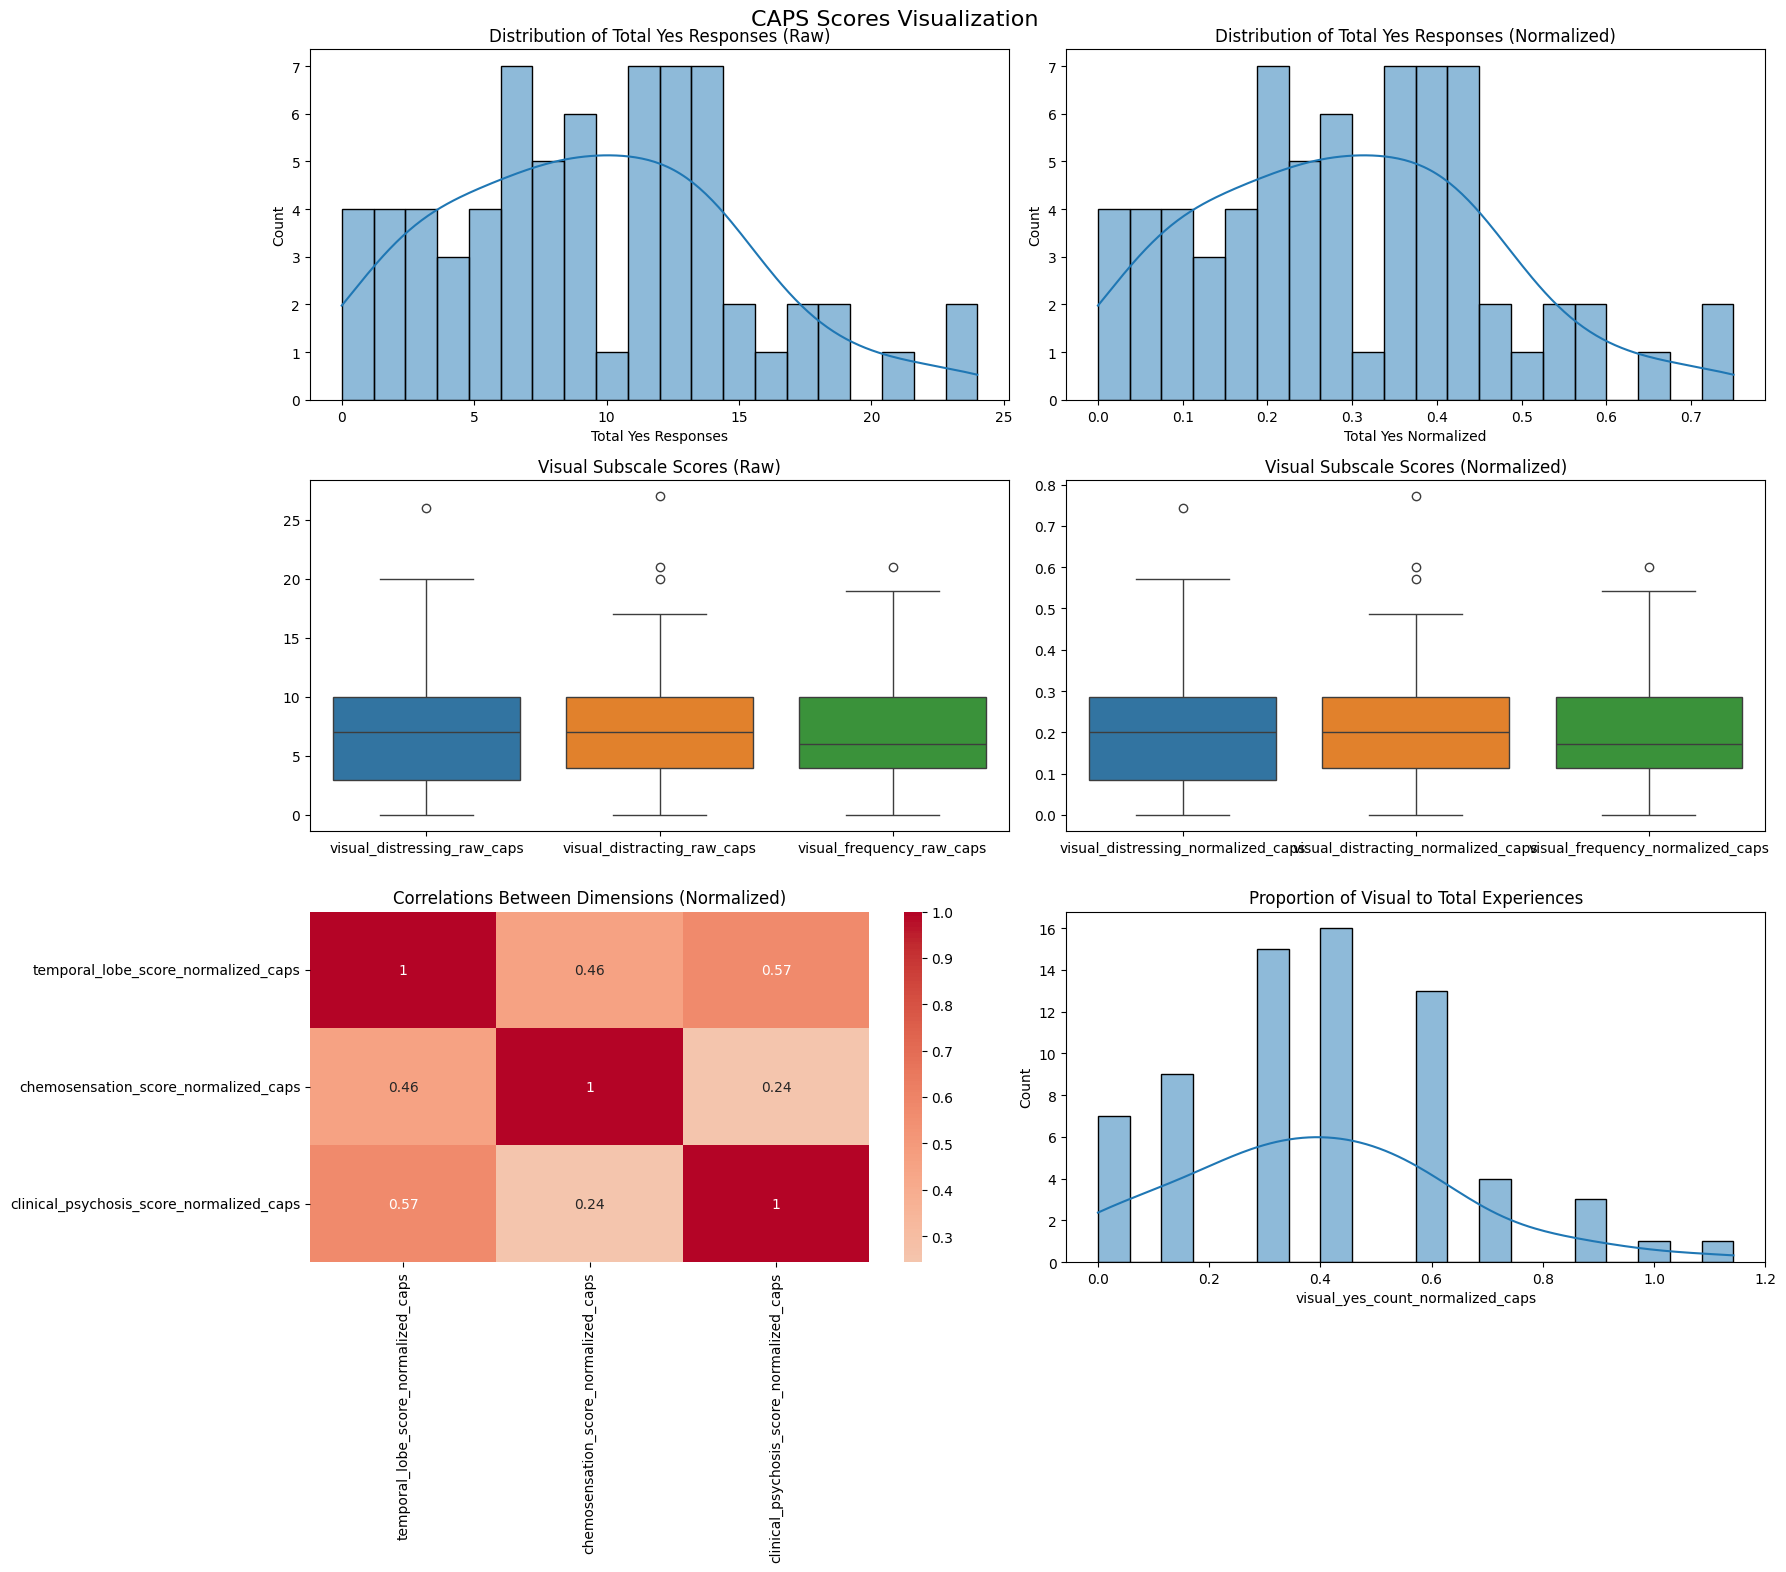

In [33]:
def visualize_caps_scores(caps_scores_df):
    """Visualize CAPS scores with raw and normalized data."""
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))
    fig.suptitle('CAPS Scores Visualization', fontsize=16)

    # Plot: Distribution of Total Yes Responses (Raw)
    sns.histplot(data=caps_scores_df['total_yes_raw_caps'], bins=20, kde=True, ax=axes[0,0])
    axes[0,0].set_title('Distribution of Total Yes Responses (Raw)')
    axes[0,0].set_xlabel('Total Yes Responses')
    
    # Plot: Distribution of Total Yes Responses (Normalized)
    sns.histplot(data=caps_scores_df['total_yes_normalized_caps'], bins=20, kde=True, ax=axes[0,1])
    axes[0,1].set_title('Distribution of Total Yes Responses (Normalized)')
    axes[0,1].set_xlabel('Total Yes Normalized')
    
    # Plot: Boxplot of Visual Subscale Scores (Raw)
    visual_cols_raw = ['visual_distressing_raw_caps', 'visual_distracting_raw_caps', 'visual_frequency_raw_caps']
    sns.boxplot(data=caps_scores_df[visual_cols_raw], ax=axes[1,0])
    axes[1,0].set_title('Visual Subscale Scores (Raw)')
    
    # Plot: Boxplot of Visual Subscale Scores (Normalized)
    visual_cols_normalized = ['visual_distressing_normalized_caps', 
                              'visual_distracting_normalized_caps', 
                              'visual_frequency_normalized_caps']
    sns.boxplot(data=caps_scores_df[visual_cols_normalized], ax=axes[1,1])
    axes[1,1].set_title('Visual Subscale Scores (Normalized)')
    
    # Plot: Heatmap of Dimension Correlations (Normalized)
    dimension_cols_normalized = [
        'temporal_lobe_score_normalized_caps',
        'chemosensation_score_normalized_caps',
        'clinical_psychosis_score_normalized_caps'
    ]
    corr_matrix = caps_scores_df[dimension_cols_normalized].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[2,0])
    axes[2,0].set_title('Correlations Between Dimensions (Normalized)')
    
    # Plot: Proportion of Visual Experiences to Total Experiences (Normalized)
    sns.histplot(data=caps_scores_df['visual_yes_count_normalized_caps'], bins=20, kde=True, ax=axes[2,1])
    axes[2,1].set_title('Proportion of Visual to Total Experiences')
    
    plt.tight_layout()
    plt.show()

# Run the visualization function with the updated DataFrame
visualize_caps_scores(caps_scores_by_participant)

In [ ]:
def calculate_cronbach_alpha_caps(caps_df):
    """Calculate Cronbach's alpha for CAPS."""
    # Pivot the CAPS data to have participants as rows and questions as columns
    caps_wide = caps_df.pivot_table(index='participant_id', 
                                    columns='question_index', 
                                    values='response', 
                                    aggfunc='first')
    
    # Replace 'yes' with 1, 'no' with 0 for binary scoring
    caps_wide = caps_wide.replace({'yes': 1, 'no': 0})
    
    # Calculate Cronbach's alpha
    alpha, ci = pg.cronbach_alpha(data=caps_wide)
    
    print(f"\nCronbach's alpha for CAPS: {alpha:.3f}")
    print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
    
    return alpha, ci

# Run the Cronbach's alpha calculation
alpha_caps, ci_caps = calculate_cronbach_alpha_caps(clean_dfs['caps'])


Cronbach's alpha for CAPS: 0.824
95% CI: [0.759, 0.879]


C:\Users\saith\AppData\Local\Temp\ipykernel_38664\4111406613.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  caps_wide = caps_wide.replace({'yes': 1, 'no': 0})


Technically this is illegal, a very imaginative AI suggested KR-20

In [40]:
def calculate_kr20(data):
    """Calculate KR-20 for dichotomous data."""
    p = data.mean(axis=0)  # Proportion of "yes" responses per item
    q = 1 - p              # Proportion of "no" responses per item
    pq_sum = (p * q).sum() # Sum of p*q across all items
    n_items = data.shape[1]
    total_variance = data.sum(axis=1).var(ddof=1)  # Variance of total scores
    kr20 = (n_items / (n_items - 1)) * (1 - pq_sum / total_variance)
    return kr20

# Example usage:
caps_wide_binary = clean_dfs['caps'].pivot_table(index='participant_id', 
                                       columns='question_index', 
                                       values='response', 
                                       aggfunc='first').replace({'yes': 1, 'no': 0})
kr20_value = calculate_kr20(caps_wide_binary)
print(f"KR-20 for CAPS: {kr20_value:.3f}")

KR-20 for CAPS: 0.827


C:\Users\saith\AppData\Local\Temp\ipykernel_38664\194196995.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aggfunc='first').replace({'yes': 1, 'no': 0})


KR-20 vs Cronbach's Alpha
KR-20: Specifically designed for binary data (yes/no). The high value (0.827) confirms that participants' binary responses on CAPS items are consistent (because the Cronbach can't be done on binary, although its outputs are similar its assumptions are still violated - bad practice)

Cronbach's Alpha (Subscales): Evaluates the consistency of continuous subscale ratings (distressing, distracting, frequency) when participants answered "yes." The overall alpha (0.634) suggests moderate consistency across all subscales.

In [48]:
def calculate_subscale_consistency_with_logging(caps_df):
    """Calculate internal consistency (Cronbach's alpha) for CAPS subscales with detailed logging."""
    
    # Filter data to include only "yes" responses
    yes_responses = caps_df[caps_df['response'] == 'yes']
    
    # Initialize results dictionary
    dimension_alphas = {}
    
    # Loop through each subscale (distressing, distracting, frequency)
    for dim in ['distressing', 'distracting', 'frequency']:
        print(f"\nProcessing subscale: {dim}")
        
        # Extract subscale values for this dimension
        dim_data = yes_responses[['participant_id', 'question_index', 'subscale']].dropna()
        dim_data[dim] = dim_data['subscale'].apply(lambda x: x.get(dim) if isinstance(x, dict) else None)
        
        # Pivot the data to wide format (participants as rows, questions as columns)
        dim_wide = dim_data.pivot_table(
            index='participant_id',
            columns='question_index',
            values=dim,
            aggfunc='first'
        )
        
        print(f"Initial shape of wide-format data for {dim}: {dim_wide.shape}")
        
        # Log missing data
        missing_items = dim_wide.isnull().sum(axis=0)
        #print(f"Missing values per question for {dim}:\n{missing_items}")
        
        # Clean the data by dropping rows/columns with excessive missing values
        dim_wide_cleaned = dim_wide.dropna(axis=1, thresh=2).dropna(axis=0, thresh=2)
        
        print(f"Shape after cleaning for {dim}: {dim_wide_cleaned.shape}")
        
        # Calculate Cronbach's alpha if there are at least 2 items
        if dim_wide_cleaned.shape[1] >= 2:
            alpha_dim, ci_dim = pg.cronbach_alpha(data=dim_wide_cleaned)
            dimension_alphas[dim] = (alpha_dim, ci_dim)
            print(f"Cronbach's alpha for {dim}: {alpha_dim:.3f}")
            print(f"95% CI: [{ci_dim[0]:.3f}, {ci_dim[1]:.3f}]")
        else:
            print(f"Not enough items to calculate Cronbach's alpha for {dim}.")
    
    return dimension_alphas

# Run the analysis with logging
subscale_alpha_results_with_logging = calculate_subscale_consistency_with_logging(clean_dfs['caps'])


Processing subscale: distressing
Initial shape of wide-format data for distressing: (67, 32)
Shape after cleaning for distressing: (65, 31)
Cronbach's alpha for distressing: 0.912
95% CI: [0.879, 0.940]

Processing subscale: distracting
Initial shape of wide-format data for distracting: (67, 32)
Shape after cleaning for distracting: (65, 31)
Cronbach's alpha for distracting: 0.872
95% CI: [0.823, 0.913]

Processing subscale: frequency
Initial shape of wide-format data for frequency: (67, 32)
Shape after cleaning for frequency: (65, 31)
Cronbach's alpha for frequency: 0.943
95% CI: [0.922, 0.961]


you can uncomment a line to see the exact questions that missed items and just how many :) 

Before merge:

VVIQ measures: ['eyes_open_raw', 'eyes_open_normalized', 'eyes_closed_raw', 'eyes_closed_normalized', 'total_raw', 'total_normalized']

CAPS measures: ['total_yes_raw_caps', 'distressing_total_raw_caps', 'distracting_total_raw_caps', 'frequency_total_raw_caps', 'temporal_lobe_score_raw_caps', 'chemosensation_score_raw_caps', 'clinical_psychosis_score_raw_caps', 'visual_yes_count_raw_caps', 'visual_distressing_raw_caps', 'visual_distracting_raw_caps', 'visual_frequency_raw_caps', 'visual_total_raw_caps', 'total_yes_normalized_caps', 'distressing_total_normalized_caps', 'distracting_total_normalized_caps', 'frequency_total_normalized_caps', 'temporal_lobe_score_normalized_caps', 'chemosensation_score_normalized_caps', 'clinical_psychosis_score_normalized_caps', 'visual_yes_count_normalized_caps', 'visual_distressing_normalized_caps', 'visual_distracting_normalized_caps', 'visual_frequency_normalized_caps', 'visual_total_normalized_caps']

After merge:

All columns: ['eyes_

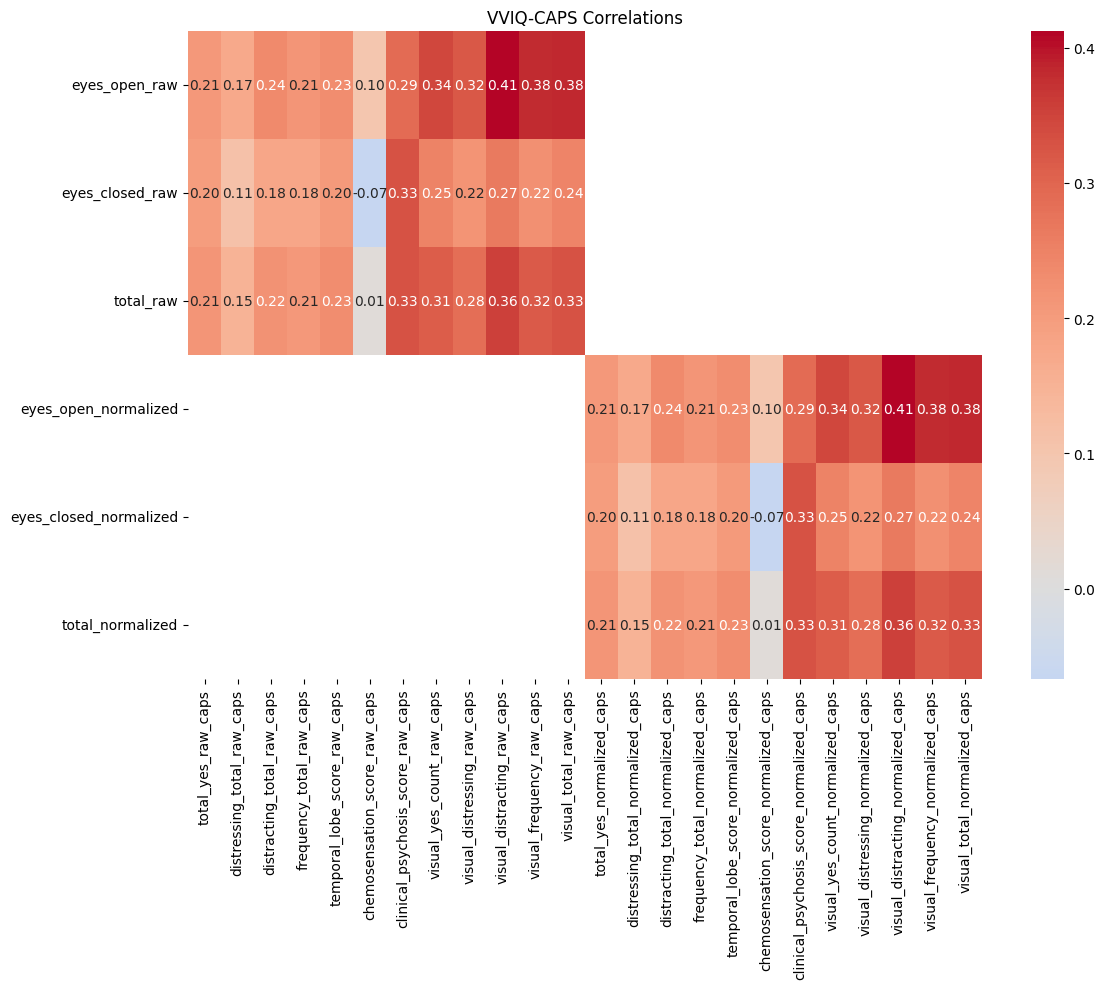


Significant correlations (p < 0.05):

eyes_open_raw vs distracting_total_raw_caps:
r = 0.237, p = 0.049

eyes_open_raw vs clinical_psychosis_score_raw_caps:
r = 0.289, p = 0.016

eyes_open_raw vs visual_yes_count_raw_caps:
r = 0.345, p = 0.004

eyes_open_raw vs visual_distressing_raw_caps:
r = 0.321, p = 0.007

eyes_open_raw vs visual_distracting_raw_caps:
r = 0.412, p = 0.000

eyes_open_raw vs visual_frequency_raw_caps:
r = 0.382, p = 0.001

eyes_open_raw vs visual_total_raw_caps:
r = 0.384, p = 0.001

eyes_closed_raw vs clinical_psychosis_score_raw_caps:
r = 0.330, p = 0.006

eyes_closed_raw vs visual_yes_count_raw_caps:
r = 0.249, p = 0.039

eyes_closed_raw vs visual_distracting_raw_caps:
r = 0.265, p = 0.027

eyes_closed_raw vs visual_total_raw_caps:
r = 0.244, p = 0.043

total_raw vs clinical_psychosis_score_raw_caps:
r = 0.330, p = 0.006

total_raw vs visual_yes_count_raw_caps:
r = 0.313, p = 0.009

total_raw vs visual_distressing_raw_caps:
r = 0.283, p = 0.018

total_raw vs vis

In [44]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_vviq_caps_correlations(vviq_df, caps_df):
    """Analyze correlations between VVIQ and CAPS scores (raw vs raw, normalized vs normalized)."""
    
    print("Before merge:")
    print("\nVVIQ measures:", vviq_df.columns.tolist())
    print("\nCAPS measures:", caps_df.columns.tolist())
    
    # Merge the dataframes on participant_id
    correlation_df = pd.merge(vviq_df, caps_df, 
                              left_index=True, 
                              right_index=True,
                              suffixes=('_vviq', '_caps'))
    
    print("\nAfter merge:")
    print("\nAll columns:", correlation_df.columns.tolist())
    
    # Define measures of interest
    vviq_measures_raw = ['eyes_open_raw', 'eyes_closed_raw', 'total_raw']
    vviq_measures_normalized = ['eyes_open_normalized', 'eyes_closed_normalized', 'total_normalized']
    
    caps_measures_raw = [col for col in caps_df.columns if '_raw_caps' in col]
    caps_measures_normalized = [col for col in caps_df.columns if '_normalized_caps' in col]
    
    # Initialize results DataFrames
    correlations = pd.DataFrame()
    p_values = pd.DataFrame()
    
    # Calculate correlations (raw vs raw)
    for vviq_measure in vviq_measures_raw:
        for caps_measure in caps_measures_raw:
            try:
                r, p = pearsonr(correlation_df[vviq_measure], correlation_df[caps_measure])
                correlations.loc[vviq_measure, caps_measure] = r
                p_values.loc[vviq_measure, caps_measure] = p
            except KeyError as e:
                print(f"Error with columns: {vviq_measure} vs {caps_measure}")
                print(f"Error message: {e}")
    
    # Calculate correlations (normalized vs normalized)
    for vviq_measure in vviq_measures_normalized:
        for caps_measure in caps_measures_normalized:
            try:
                r, p = pearsonr(correlation_df[vviq_measure], correlation_df[caps_measure])
                correlations.loc[vviq_measure, caps_measure] = r
                p_values.loc[vviq_measure, caps_measure] = p
            except KeyError as e:
                print(f"Error with columns: {vviq_measure} vs {caps_measure}")
                print(f"Error message: {e}")
    
    # Visualize correlations with a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlations, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f')
    plt.title('VVIQ-CAPS Correlations')
    plt.tight_layout()
    plt.show()
    
    # Print significant correlations
    print("\nSignificant correlations (p < 0.05):")
    for vviq_measure in correlations.index:
        for caps_measure in correlations.columns:
            try:
                r = correlations.loc[vviq_measure, caps_measure]
                p = p_values.loc[vviq_measure, caps_measure]
                if p < 0.05:
                    print(f"\n{vviq_measure} vs {caps_measure}:")
                    print(f"r = {r:.3f}, p = {p:.3f}")
            except KeyError:
                continue
    
    return correlations, p_values, correlation_df

# Run the updated correlation analysis function
correlations, p_values, correlation_data = analyze_vviq_caps_correlations(
    vviq_scores_by_participant,
    caps_scores_by_participant
)

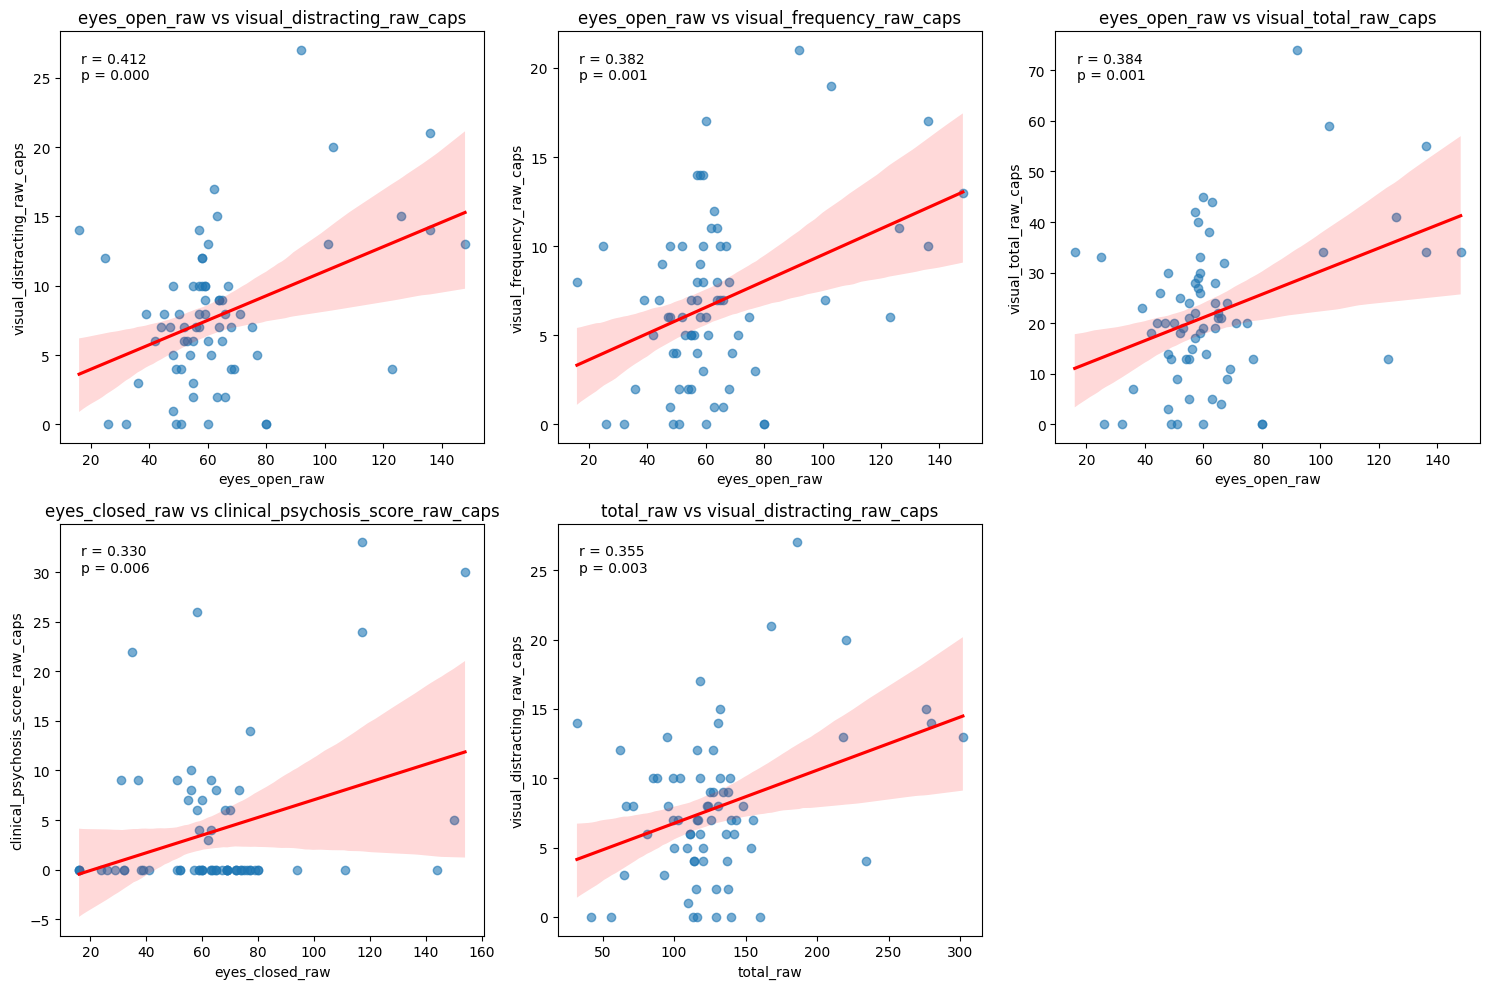

In [37]:
def visualize_significant_correlations_with_annotations(correlation_data, significant_pairs):
    """Visualize significant correlations with annotations for r and p-values."""
    
    # Create subplots
    num_plots = len(significant_pairs)
    cols = 3  # Number of columns in the grid
    rows = (num_plots // cols) + (num_plots % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()
    
    for i, (vviq_measure, caps_measure) in enumerate(significant_pairs):
        ax = axes[i]
        
        # Scatterplot with regression line
        sns.regplot(
            x=correlation_data[vviq_measure],
            y=correlation_data[caps_measure],
            ax=ax,
            scatter_kws={'alpha': 0.6},
            line_kws={'color': 'red'}
        )
        
        # Calculate r and p-values
        r, p = pearsonr(correlation_data[vviq_measure], correlation_data[caps_measure])
        
        # Annotate plot with r and p-values
        ax.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3f}', 
                transform=ax.transAxes, verticalalignment='top', fontsize=10)
        
        # Set titles and labels
        ax.set_title(f'{vviq_measure} vs {caps_measure}')
        ax.set_xlabel(vviq_measure)
        ax.set_ylabel(caps_measure)
    
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Define significant pairs based on your results
significant_pairs = [
    ('eyes_open_raw', 'visual_distracting_raw_caps'),
    ('eyes_open_raw', 'visual_frequency_raw_caps'),
    ('eyes_open_raw', 'visual_total_raw_caps'),
    ('eyes_closed_raw', 'clinical_psychosis_score_raw_caps'),
    ('total_raw', 'visual_distracting_raw_caps'),
]

# Visualize significant correlations with annotations
visualize_significant_correlations_with_annotations(correlation_data, significant_pairs)

should probably add the normalized ones to the above plot tbh


# **Key Observations**

## **1. VVIQ Internal Consistency**
- **Cronbach's alpha for eyes open**: 0.798  
  - 95% CI: [0.706, 0.866]
- **Cronbach's alpha for eyes closed**: 0.892  
  - 95% CI: [0.843, 0.928]
- **Overall Cronbach's alpha**: 0.888  
  - 95% CI: [0.843, 0.924]

These results indicate good internal consistency for the VVIQ questionnaire, with higher reliability for the "eyes closed" condition compared to "eyes open."

---

## **2. CAPS Internal Consistency**
- **Cronbach's alpha for CAPS**: 0.824  
  - 95% CI: [0.759, 0.879]
- **KR-20 for CAPS**: 0.827  

Both metrics indicate good internal consistency for the binary responses on the CAPS questionnaire.

### Subscale Consistency
- **Distressing**:
  - Cronbach's alpha: 0.912  
    - 95% CI: [0.879, 0.940]  
- **Distracting**:
  - Cronbach's alpha: 0.872  
    - 95% CI: [0.823, 0.913]  
- **Frequency**:
  - Cronbach's alpha: 0.943  
    - 95% CI: [0.922, 0.961]  

These results suggest excellent internal consistency for all three subscales of CAPS.

---

## **3. VVIQ and Training Accuracy Correlations**
No significant correlations were found between VVIQ scores (eyes open, eyes closed, total) and training accuracy, even after removing participants with accuracy below 50%.

---

## **4. CAPS Dimensions**
### Defined Dimensions:
- *Temporal Lobe*: Questions [1–12]  
- *Chemosensation*: Questions [26–29]  
- *Clinical Psychosis*: Questions [30–32]  

### Visual Perception Questions:
Questions related to visual perception include [1, 3, 19, 20, 26, 23, and 24].

---

## **5. Significant Correlations Between VVIQ and CAPS**
### Eyes Open (Raw and Normalized):
- Strong correlations with visual dimensions of CAPS:
  - **Visual Distracting**: *r = 0.412, p  .89`.
3. Temporal lobe-related questions dominate in terms of score magnitude compared to chemosensation or clinical psychosis dimensions.

### VVIQ Scores
1. The "eyes closed" condition shows higher internal consistency than "eyes open."
2. No significant relationship was found between VVIQ scores and training accuracy.

In [ ]:
# Cell 1: Combine clean participants with original data
def process_evolution_data(valid_results, clean_dfs):
    # Get list of clean participants (those who passed attention checks)
    clean_participants = clean_dfs['participants'].index.tolist()
    
    # Process only clean participants' data
    results = {}
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        if participant_id in clean_participants:  # Only process clean participants
            if 'evolution_summary' in result:
                results[participant_id] = {}
                
                for gen_data in result['evolution_summary']:
                    session = gen_data['session']
                    if session not in results[participant_id]:
                        results[participant_id][session] = {}
                    
                    generation = gen_data['generation']
                    if 'selected_parents' in gen_data:
                        results[participant_id][session][generation] = {
                            'selected': [p['filtered_image'] for p in gen_data['selected_parents']]
                        }
    
    return results

def plot_participant_sessions_with_combined(participant_data, participant_id):
    # First plot individual sessions
    for session, session_data in participant_data.items():
        generations = sorted(session_data.keys())
        n_gens = len(generations)
        
        if n_gens == 0:
            print(f"No generations found for Participant {participant_id}, Session {session}")
            continue
            
        fig, axes = plt.subplots(1, n_gens, figsize=(3*n_gens, 3))
        if n_gens == 1:
            axes = [axes]
        
        for idx, gen in enumerate(generations):
            gen_images = []
            for img_base64 in session_data[gen]['selected']:
                try:
                    img = decode_base64_image(img_base64)
                    gen_images.append(img)
                except:
                    continue
                    
            if gen_images:
                composite = create_composite_image(gen_images)
                axes[idx].imshow(composite, cmap='gray')
                axes[idx].axis('off')
                axes[idx].set_title(f'Gen {gen}')
        
        plt.suptitle(f'Participant {participant_id} - Session {session}')
        plt.tight_layout()
        plt.show()
        plt.close()

    # Then create and plot combined sessions
    combined_generations = {}
    for session, session_data in participant_data.items():
        for gen, gen_data in session_data.items():
            if gen not in combined_generations:
                combined_generations[gen] = []
            combined_generations[gen].extend(gen_data['selected'])

    # Plot combined sessions
    fig, axes = plt.subplots(1, len(combined_generations), figsize=(3*len(combined_generations), 3))
    if len(combined_generations) == 1:
        axes = [axes]

    for idx, (gen, gen_images_base64) in enumerate(sorted(combined_generations.items())):
        gen_images = []
        for img_base64 in gen_images_base64:
            try:
                img = decode_base64_image(img_base64)
                gen_images.append(img)
            except:
                continue

        if gen_images:
            composite = create_composite_image(gen_images)
            axes[idx].imshow(composite, cmap='gray')
            axes[idx].axis('off')
            axes[idx].set_title(f'Gen {gen}')

    plt.suptitle(f'Participant {participant_id} - Combined Sessions')
    plt.tight_layout()
    plt.show()
    plt.close()

# Update the visualization function in your pipeline
def visualize_clean_evolution(valid_results, clean_dfs):
    clean_participant_data = process_evolution_data(valid_results, clean_dfs)
    
    print("Clean Evolution Data Summary:")
    for participant_id, data in clean_participant_data.items():
        print(f"\nParticipant {participant_id}:")
        for session, session_data in data.items():
            print(f"  Session {session}: {len(session_data)} generations")
            print(f"  Available generations: {sorted(session_data.keys())}")
    
    for participant_id, data in clean_participant_data.items():
        print(f"\nVisualizing Participant {participant_id}")
        plot_participant_sessions_with_combined(data, participant_id)

# Run the analysis
visualize_clean_evolution(valid_results, clean_dfs)